# Mean Reversion & Moving Averages
## 1. Research Question
We want to explore the EUR-GBP exchange rate, and examine when and whether the process is mean reverting. If it is indeed mean reverting, then we can extract a half-life of mean reversion from the time signal, and use that to parametrize a moving average trading strategy.

## 2. Data & Mean Reversion Tests
For data, we pull the last 20 years of EURGBP data at a frequency of 1 day. We then look at approximately 3 year long windows (1100 days), starting approximately every quarter (90 days). We then run the ADF test on each block to determine whether the signal is mean reverting during this period or not. Specifically, we look windows when p < 0.05.

[*********************100%***********************]  1 of 1 completed


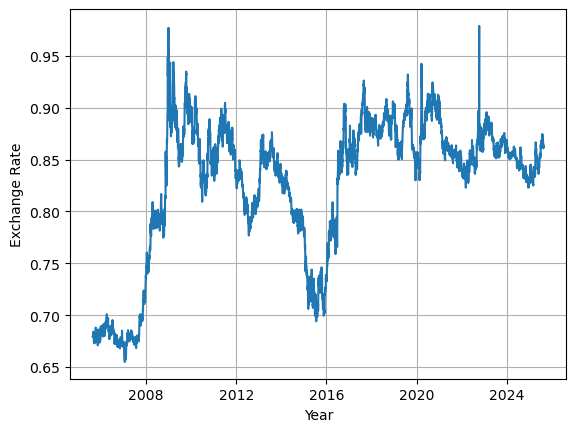

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Example: Get EUR/CHF data
data = yf.download("EURGBP=X", start='2005-08-21', end='2025-08-21', interval='1d', auto_adjust=True)
data.describe()

In [2]:
start_idx = 0
end_idx = 1100
while True:
    # Extract subset
    df = data.iloc[start_idx:end_idx]

    # Extract close prices
    prices = df['Close'].dropna()

    # Run Augmented Dickey-Fuller test
    result = adfuller(prices)

    # Print results
    if result[1] < 0.05:
        print("start_idx, end_idx, ADF Statistic, p-value:", start_idx, end_idx, result[0], result[1])    

    # Move window forward by 90 days
    start_idx = start_idx + 90
    end_idx = end_idx + 90
    if end_idx > len(data):
        break
    

start_idx, end_idx, ADF Statistic, p-value: 630 1730 -2.971851610151223 0.03760803870753003
start_idx, end_idx, ADF Statistic, p-value: 2700 3800 -3.337548410329227 0.013281248617048885
start_idx, end_idx, ADF Statistic, p-value: 2790 3890 -3.672694709270794 0.004514038903399952
start_idx, end_idx, ADF Statistic, p-value: 2880 3980 -3.7741369500854924 0.0031832931339042555
start_idx, end_idx, ADF Statistic, p-value: 2970 4070 -3.34030973813356 0.013170010572769281
start_idx, end_idx, ADF Statistic, p-value: 3060 4160 -3.40258040303532 0.010871219750180206
start_idx, end_idx, ADF Statistic, p-value: 3150 4250 -3.1829730339815585 0.020991664913975354


## 3. Extracting Half-Life of Mean Reversion
Great! Looks like there was a time window of a few years when the signal was mean reverting. Let's plot the signal to get a feel for it, then let's regress an AR(1) model on it to obtain a half-life value. 

In [6]:
# Extract data and plot
window_start = 2700
window_end = 3500
df = data.iloc[window_start:window_end]

# Regression to find half life
y = np.array([y[0] for y in df['Close'].dropna().values.tolist()])
y_bar = y - np.mean(y)
y_diff = y[1:]-y[:-1]
t = df.index.tolist()
print(t[0], t[-1])

# Build an AR(1) model
model_fit = sm.OLS(y_diff,-y_bar[:-1]).fit() # Y, X
half_life = np.log(2)/model_fit.params[0]

2016-01-05 00:00:00 2019-01-30 00:00:00


## 4. Algorithm: Moving Z-score
Now that we know the half-life of reversion is about 51 days, we can use that to implement a simple moving Z-score algorithm. The idea is pretty starightforward. We have a natural window to implement lookbacks. Using this, we can compute rolling means and standard deviations over this window, and use that to determine a Z-score. If the Z-score exceeds a certain threshold (the enter-threshold), that means the rate has gone too far above the mean, which means GBP is overvalued against the EUR. When this happens, we need to stock up on EUR, and vice versa. We treat EUR as our account currency, and we buy and sell 5 units of EUR whenever the signal tells us to do so.

We'll look into improvements to this algorithm later on, like adding weights to the moving average window, as well as trading an amount proportional to the Z-score, rather than a fixed amount of 5 units. 

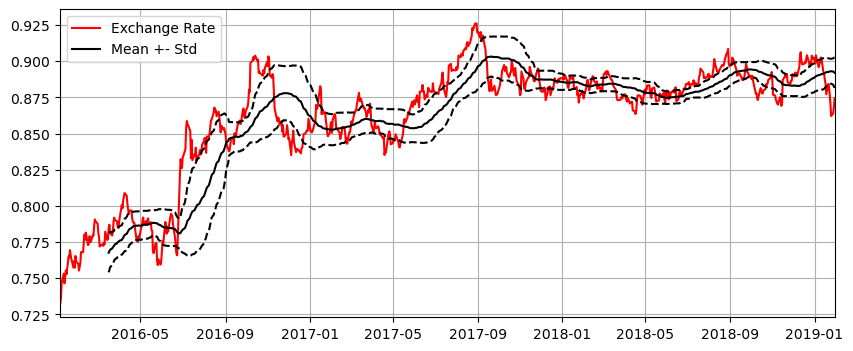

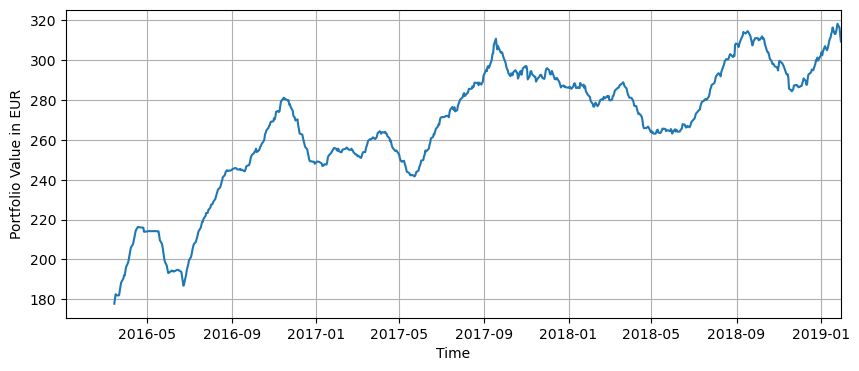

In [40]:
# Rolling mean & std over half-life window
lookback = 51  # half-life

# Extract test data
test_window_start = 2700
test_window_end = 3500
df = data.iloc[test_window_start:test_window_end]
y = np.array([y[0] for y in df['Close'].dropna().values.tolist()])
t = df.index.tolist()

rolling_mean = np.array([np.mean(y[i-lookback:i]) for i in range(lookback, len(y))])
rolling_std  = np.array([np.std(y[i-lookback:i]) for i in range(lookback, len(y))])

# Now lets start trading
z_crit = 1.0

# Plot price and 51-day rolling mean
plt.figure(1, figsize=(10, 4))
plt.plot(t,y, color='red')
plt.plot(t[lookback:], rolling_mean, color='black')
plt.legend(['Exchange Rate', 'Mean +- Std'])
plt.plot(t[lookback:], rolling_mean + z_crit*rolling_std, '--', color='black')
plt.plot(t[lookback:], rolling_mean - z_crit*rolling_std, '--', color='black')
plt.xlim([t[0], t[-1]])
plt.grid()
plt.savefig('exchange_rate_with_limits.png')

eur_pos = 100
gbp_pos = 100
eur_val = [eur_pos]
gbp_val = [gbp_pos]
total_val = [eur_pos + gbp_pos * y[lookback-1]]
trd_size = 5
z_score_prev = (y[lookback-1] - rolling_mean[0])/rolling_std[0]
exited = False
for i in range(lookback, len(y)):
    mu = rolling_mean[i-lookback]
    sigma = rolling_std[i-lookback]
    z_score = (y[i] - mu)/sigma

    if z_score >= z_crit:
        # GBP doing too well, and it's about to mean revert, so sell GBP
        eur_pos = eur_pos + trd_size
        gbp_pos = gbp_pos - trd_size * y[i]
        exited = False
    elif z_score <= -z_crit:
        # GBP doing too badly, and it's about to mean revert, so buy GBP
        eur_pos = eur_pos - trd_size
        gbp_pos = gbp_pos + trd_size * y[i]
        exited = False
    else:
        pass
    eur_val.append(eur_pos)
    gbp_val.append(gbp_pos)
    total_val.append(eur_pos + gbp_pos * y[i])

plt.figure(2, figsize=(10, 4))
plt.plot(t[lookback-1:],total_val)
plt.xlabel('Time')
plt.ylabel('Portfolio Value in EUR')
plt.grid()
plt.xlim([t[0], t[-1]])
plt.savefig('portfolio_vs_time.png')

## 5. Performance Analysis
Right, let's talk about performance. Below are the calculations for Sharpe Ratio and Annualized Returns, which are ~1.9 and 28.8% respectively. Good performance, but our training and test data are effectively the same. What happens if we change the start and end window to be the entire interval?

In [37]:
# Sharpe Ratio
returns = np.array([(total_val[i]-total_val[i-1])/total_val[i-1] for i in range(1,len(total_val))])
N_period = 252
risk_free_rate = 0.04 / N_period # 4 percent converted to daily rate
ret_mean = np.mean(returns)
ret_std = np.std(returns)
sharpe_ratio = (ret_mean - risk_free_rate)/ret_std * np.sqrt(N_period)

# Annualized return
N_years = (window_end-window_start)/365
abs_return = (total_val[-1]-total_val[0])/total_val[0]
annualized_return = (1+abs_return)**(1/N_years) - 1

print('Sharpe Ratio = ', sharpe_ratio)
print('Annualized Returns in Percentage = ', annualized_return * 100)

Sharpe Ratio =  1.8932711883588738
Annualized Returns in Percentage =  28.78745004723884
